In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
def INFO(what):
    print(f">>>>>>> {what} >>>>>>>")

In [3]:
INFO("Đặt đường dẫn dataset")
data_path = r"./bank+marketing/bank-additional/bank-additional/bank-additional-full.csv"

INFO("Phân tách csv, ký tự phân tách là `;`")
df = pd.read_csv(data_path, sep=';')

INFO("Kiểm tra kiểu dữ liệu của mỗi cột")
print(df.dtypes)

INFO("Thống kê số lượng thuộc tính theo kiểu dữ liệu")
print("\nSố lượng đặc trưng theo kiểu dữ liệu:")
print(df.dtypes.value_counts())

INFO("Kiểm tra một số dòng đầu tiên để xem dữ liệu thực tế")
INFO("Mẫu dữ liệu:")
print(df.describe())

>>>>>>> Đặt đường dẫn dataset >>>>>>>
>>>>>>> Phân tách csv, ký tự phân tách là `;` >>>>>>>
>>>>>>> Kiểm tra kiểu dữ liệu của mỗi cột >>>>>>>
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object
>>>>>>> Thống kê số lượng thuộc tính theo kiểu dữ liệu >>>>>>>

Số lượng đặc trưng theo kiểu dữ liệu:
object     11
int64       5
float64     5
Name: count, dtype: int64
>>>>>>> Kiểm tra một số dòng đầu tiên để xem dữ liệu thực tế >>>>>>>
>>>>>>> Mẫu dữ liệu: >>>>>>>
               age      durati

In [4]:
INFO("Thống kê các cột categorical")
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"\n#### {col} ####:")
    print(df[col].value_counts())

>>>>>>> Thống kê các cột categorical >>>>>>>

#### job ####:
job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

#### marital ####:
marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64

#### education ####:
education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

#### default ####:
default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

#### housing ####:
housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64

#### l

In [5]:
INFO("Kiểm tra biến Y xem có cân bằng không")
yes_count = (df['y'] == "yes").sum()
no_count = (df['y'] == "no").sum()
print(f'#yes = {yes_count}; %ratio = {100*(yes_count/(no_count+yes_count))}%')
print(f'#no = {no_count}; %ratio = {100*(no_count/(no_count+yes_count))}%')
INFO("Từ kết quả, cho thấy dữ liệu không cân bằng!")

>>>>>>> Kiểm tra biến Y xem có cân bằng không >>>>>>>
#yes = 4640; %ratio = 11.265417111780131%
#no = 36548; %ratio = 88.73458288821988%
>>>>>>> Từ kết quả, cho thấy dữ liệu không cân bằng! >>>>>>>


In [6]:
# INFO("Mã hóa dữ liệu ")
# label_encoders = {}
# categorical_cols = [col for col in df.columns if df[col].dtype == 'object' and col != 'y']
# for col in categorical_cols:
#     print(f"Processing `{col}` \t\tcolumn \t\t/ `{df[col].dtype}`...")
#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col])
#     label_encoders[col] = le
# # Encode y separately
# df['y'] = df['y'].map({'yes': 1, 'no': 0})  # Or use LabelEncoder if preferred
# df.describe()

In [7]:
INFO("Chia IN/OUT")
X, Y = df.drop(columns=['y']), df['y'].map({'yes': 1, 'no': 0})
INFO("X:")
print(X.describe())
INFO("Y:")
print(Y.describe())

>>>>>>> Chia IN/OUT >>>>>>>
>>>>>>> X: >>>>>>>
               age      duration      campaign         pdays      previous  \
count  41188.00000  41188.000000  41188.000000  41188.000000  41188.000000   
mean      40.02406    258.285010      2.567593    962.475454      0.172963   
std       10.42125    259.279249      2.770014    186.910907      0.494901   
min       17.00000      0.000000      1.000000      0.000000      0.000000   
25%       32.00000    102.000000      1.000000    999.000000      0.000000   
50%       38.00000    180.000000      2.000000    999.000000      0.000000   
75%       47.00000    319.000000      3.000000    999.000000      0.000000   
max       98.00000   4918.000000     56.000000    999.000000      7.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx     euribor3m   nr.employed  
count  41188.000000    41188.000000   41188.000000  41188.000000  41188.000000  
mean       0.081886       93.575664     -40.502600      3.621291   5167.035911  
std    

In [8]:
INFO("Chia tập dữ liệu với stratify để đảm bảo tỷ lệ lớp ")
test_size=0.1 
X_train, X_test, Y_train, Y_test = train_test_split(
    X, 
    Y, 
    test_size=test_size, 
    random_state=42, 
    stratify=Y
)
INFO("X_train:")
print(X_train.head())
INFO("Y_train:")
print(Y_train.head())

>>>>>>> Chia tập dữ liệu với stratify để đảm bảo tỷ lệ lớp  >>>>>>>
>>>>>>> X_train: >>>>>>>
       age          job   marital            education  default housing loan  \
8061    52   technician  divorced  professional.course  unknown     yes   no   
25300   36   management   married    university.degree       no     yes   no   
17667   53  blue-collar   married          high.school       no     yes  yes   
37400   45  blue-collar    single             basic.9y       no     yes   no   
4629    60    housemaid   married          high.school  unknown     yes   no   

         contact month day_of_week  duration  campaign  pdays  previous  \
8061   telephone   jun         mon        56         8    999         0   
25300   cellular   nov         tue       267         2    999         0   
17667   cellular   jul         mon       243         2    999         0   
37400   cellular   aug         wed       249         1      4         1   
4629   telephone   may         wed        74       

In [9]:
INFO("Training class distribution:")
print(Y_train.value_counts(normalize=True) * 100)
INFO("Test class distribution:")
print(Y_test.value_counts(normalize=True) * 100)

>>>>>>> Training class distribution: >>>>>>>
y
0    88.734522
1    11.265478
Name: proportion, dtype: float64
>>>>>>> Test class distribution: >>>>>>>
y
0    88.73513
1    11.26487
Name: proportion, dtype: float64


In [10]:
INFO("Tách dữ liệu số (numberical) và dữ liệu dạng phân loại (categorical)")
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
INFO("Tách target và features của lớp dữ liệu categorical")
categorical_features.remove('y')  

>>>>>>> Tách dữ liệu số (numberical) và dữ liệu dạng phân loại (categorical) >>>>>>>
>>>>>>> Tách target và features của lớp dữ liệu categorical >>>>>>>


In [11]:
INFO("Xây dựng pipeline với OneHotEncoder và SMOTE")
INFO("Xác định bộ tiền xử lý với OneHotenCoder cho các tính năng phân loại")
scaler = StandardScaler()
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
preprocessor = ColumnTransformer([
    ('num', scaler, numerical_features),
    ('cat', ohe, categorical_features)
])

>>>>>>> Xây dựng pipeline với OneHotEncoder và SMOTE >>>>>>>
>>>>>>> Xác định bộ tiền xử lý với OneHotenCoder cho các tính năng phân loại >>>>>>>


In [12]:
voting_clf = VotingClassifier(
    estimators=[
        ('lr', ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', LogisticRegression(solver='liblinear', random_state=42))
        ])),
        ('rf', ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', RandomForestClassifier(random_state=42))
        ])),
        ('xgb', ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', XGBClassifier(eval_metric='logloss', random_state=42))
        ]))
    ],
    voting='soft'
)
param_grid = {
    'lr__smote__sampling_strategy': [0.3, 0.5, 0.7],
    'rf__smote__sampling_strategy': [0.3, 0.5, 0.7],
    'xgb__smote__sampling_strategy': [0.3, 0.5, 0.7],
    'lr__classifier__C': [0.1, 1.0, 10.0],
    'rf__classifier__max_depth': [10, 20, None],
    'xgb__classifier__learning_rate': [0.01, 0.1]
}

In [13]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    voting_clf,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

In [14]:
import os
import joblib

best_threshold=0.7

model_file = "best_model.pkl"
if os.path.exists(model_file):
    INFO("Tệp best_model.pkl tồn tại, đang tải mô hình...")
    loaded_model = joblib.load(model_file)
    
    INFO("Đánh giá mô hình đã tải trên tập test")
    Y_prob_loaded = loaded_model.predict_proba(X_test)[:, 1]
    Y_pred_loaded = (Y_prob_loaded >= best_threshold).astype(int)  # Use the best threshold
    print(classification_report(Y_test, Y_pred_loaded, target_names=['no', 'yes']))
    print(f"Accuracy: {accuracy_score(Y_test, Y_pred_loaded)}")
else:
    INFO("Tệp best_model.pkl không tồn tại, lưu mô hình hiện tại...")

>>>>>>> Tệp best_model.pkl tồn tại, đang tải mô hình... >>>>>>>


>>>>>>> Đánh giá mô hình đã tải trên tập test >>>>>>>
              precision    recall  f1-score   support

          no       0.93      0.98      0.95      3655
         yes       0.74      0.41      0.53       464

    accuracy                           0.92      4119
   macro avg       0.83      0.70      0.74      4119
weighted avg       0.91      0.92      0.91      4119

Accuracy: 0.9174556931294003


In [15]:
INFO("Đánh giá VotingClassifier với GridSearchCV")
grid_search.fit(X_train, Y_train)

import joblib
joblib.dump(grid_search.best_estimator_, 'best_model.pkl')

>>>>>>> Đánh giá VotingClassifier với GridSearchCV >>>>>>>
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


['best_model.pkl']

In [16]:
INFO("Các tham số được chọn (best parameters):")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
INFO("Điểm số F1-macro tốt nhất (cross-validation):")
print(f"{grid_search.best_score_:.3f}")

>>>>>>> Các tham số được chọn (best parameters): >>>>>>>
lr__classifier__C: 1.0
lr__smote__sampling_strategy: 0.7
rf__classifier__max_depth: None
rf__smote__sampling_strategy: 0.5
xgb__classifier__learning_rate: 0.1
xgb__smote__sampling_strategy: 0.3
>>>>>>> Điểm số F1-macro tốt nhất (cross-validation): >>>>>>>
0.801


In [17]:
Y_prob = grid_search.predict_proba(X_test)[:, 1]
Y_pred = (Y_prob >= 0.7).astype(int) 
print(classification_report(Y_test, Y_pred, target_names=['no', 'yes']))
print(f"Accuracy: {accuracy_score(Y_test, Y_pred)}")

              precision    recall  f1-score   support

          no       0.93      0.98      0.95      3655
         yes       0.74      0.41      0.53       464

    accuracy                           0.92      4119
   macro avg       0.83      0.70      0.74      4119
weighted avg       0.91      0.92      0.91      4119

Accuracy: 0.9174556931294003


>>>>>>> Hiển thị tầm quan trọng của đặc trưng >>>>>>>


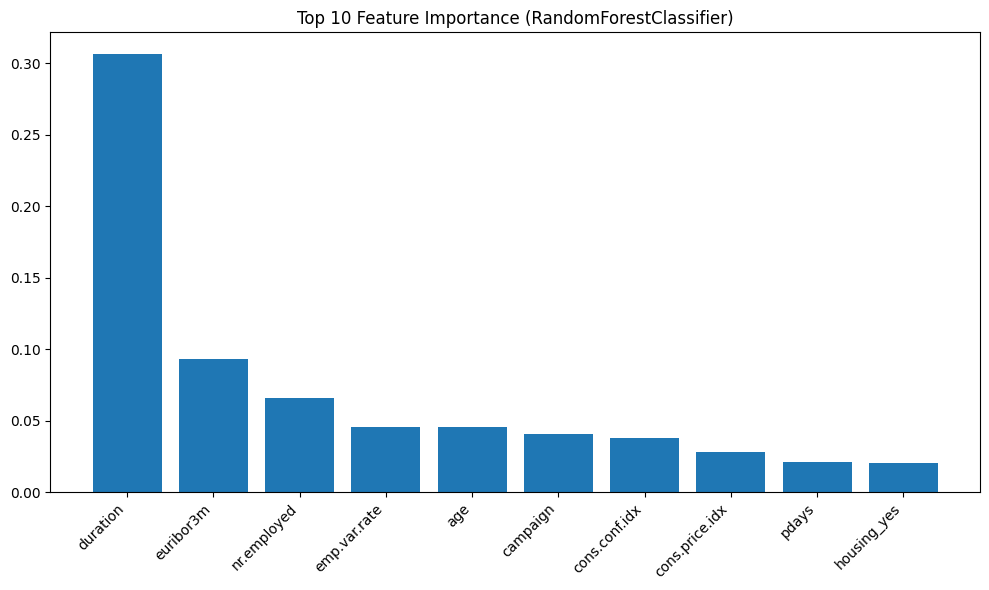

>>>>>>> Top 10 đặc trưng quan trọng: >>>>>>>
duration: 0.3062
euribor3m: 0.0932
nr.employed: 0.0657
emp.var.rate: 0.0455
age: 0.0454
campaign: 0.0407
cons.conf.idx: 0.0378
cons.price.idx: 0.0280
pdays: 0.0210
housing_yes: 0.0207


In [18]:
INFO("Hiển thị tầm quan trọng của đặc trưng")
# Access the RandomForestClassifier pipeline from the VotingClassifier
rf_pipeline = grid_search.best_estimator_.named_estimators_['rf']
# Now access the steps within the RandomForestClassifier pipeline
ohe_features = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([numerical_features, ohe_features])
importances = rf_pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1][:10]  # Top 10 features
plt.figure(figsize=(10, 6))
plt.bar(range(10), importances[indices], align='center')
plt.xticks(range(10), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.title("Top 10 Feature Importance (RandomForestClassifier)")
plt.tight_layout()
plt.show()

INFO("Top 10 đặc trưng quan trọng:")
for i in indices[:10]:
    print(f"{feature_names[i]}: {importances[i]:.4f}")